

# Harvard Art Museum Dynamic Image Search and Recommendation
Final Project CSCI S-108 Data Mining, Discovery, and Exploration

Bridget Atchison-Nevel

Professor: Stephen Elston

 May 2025

## Executive summary
---

### Problem Statement:
The Harvard Art Museums Collection's Catalog is a a digital repository of all 250,000 art objects contained in the collection. The current public access point for searching this extensive collection is a search bar on the HAM website that performs a keyword search, often yielding less-than-optimal results.

The current search is performed by a SQL-style based lookup call to the database. However, such a lookup frequently fails to return relevant results when the keywords are visual in nature. For instance, the search term ‘blue painting’ returns both non-painting items and paintings that aren’t blue. Another issue is that the search seems to be strict, as ‘ancient Chinese vase’ returns no records, while ‘Chinese vase’ returns 132 items, many of which are ancient. Furthermore, any mistyping or spelling error in the search terms results in no records because there’s no natural language processing (NLP) applied to the search terms, causing ‘photo’ and ‘photograph’ to return vastly different numbers of items.

This limited search approach is inadequate for anyone seeking to perform a search based on visual elements. My objective is to develop a search and recommendation system that returns relevant items and enables users to ‘like’ their preferred images. The recommender will then return images that closely resemble ‘liked’ images. Initially, this search will begin with a user generated query and then will continue to be driven by user preferences. 

### Value of Project
The Harvard Museum Collections provide a digital platform for anyone interested in exploring their extensive collection. Users can browse curated collections or use the search bar to find specific items. However, the search function is limited and lacks the ability to prioritize personal preferences. As consumers accustomed to algorithmic searches, we often overlook systems without optimized search or recommendation features.

One challenge is that cultural institutions like museums, libraries, and public archives are not consumer-driven and lack the financial resources to develop these tools. In our increasingly capitalist society, AI resources are heavily focused on corporate escapes, leaving institutions serving the arts behind.

This project is crucial because it serves individuals seeking art for academic or personal reasons. While there’s no financial incentive, investing in this project is essential.

### Results  
I have created a dynamic system that successfully collects a user query and returns images of the most similar objects in the database. I have provided a Jupyter notebook widget-based UI where the user is able to click on images to 'like' them. Clicking again will unlike the images. At any point, the user is able to query the database for new recommendations based on their liked images. There is a button to clear all likes. The search bar additionally remains throughout the process, and a new query-based search can be performed at any time.


## Discussion of Techniques Employed
---
### Data Selection 
I have used the 'object' table of the HAM database as well as the ‘annotations' table. There are approximately 250,000 object records. I excluded objects that did not have Machine Generated Descriptions. The final count of objects available for my recommender query is 117,243.  Each object record has 79 fields. I spent a considerable amount of time exploring the ability of available fields to identify the objects. I began working with a toy version of the data, 24,000 records long and eventually pulled all 117,243 records into the recommender.

In the final product, each object is represented as both an image: CLIP embedded image vector, 
and as a text: a tf-idf matrix vector (created from the merged Machine generated annotations and record text fields. )

### Embedding with CLIP
I used OpenAI’s CLIP (Contrastive Language–Image Pre-training) to vectorize the images. CLIP is a joint image and text embedding model trained using 400 million image and text pairs in a self-supervised way. This model has image processing capabilities similar to ImageNet and ResNet but performs better with high level sematics and is known to be better at processing artwork.(Conde and Turgutlu, 2021) I had originally planned to embed the query text with CLIP and be able to search the image space with the text. This approach did not return good results. The problem may have been that often the user query text is just a few words. This approach may work better with longer search queries. 

Once embedded using CLIP, the HAM art objects were easy to compare via cosine similarity. The results were quite stunning.

### Embedding with TF-IDF using HAM ML Annotations
To create a text embedding, I merged the AI-generated descriptions with the object record fields: title, period, classification, division, data, department, artist, culture, and medium. The AI annotations are rich descriptions of object images but lack historical data like artist and date, so appending these fields creates a more complete representation to be used for text search.  I then chose Tf-Idf (Term Frequency Inverse Document Frequency) as the text transformation to use for comparison. This approach made sense. Tfidf has been successfully used in other search engines as well as text classification. Ultimately, these text vectors are compared using cosine similarity for a similarity metric.

### Similarity Searches and Vector Store FAISS
I indexed each of my embedding sets with Faiss (Facebook AI Similarity Search). This library allows a nearest neighbor search over a large set at some amazing speeds. There are options to use L2 norms, or cosine distance for similarity, and techniques like LSH or Hierarchical Navigable Small World graph exploration. There are options to encode vectors with different levels of compression, trading for speed and size. I explored these options and found that for my dataset size, the standard FlatIndex search with cosine similarity metrics was the best option.

###

## Flow for Dynamic Search and Recommedation System
---
* After much consideration and trial and error, I have transformed each art object record into just 2 metrics that will be used within the recommendation process:


  1. CLIP-based image vectors (using FAISS flat index cosine similarity search for comparison) 
  2. Textual data (title, artist, data, division, culture, etc.), concatenated with ML-created annotations and then vectorized with TF-IDF.  (again using FAISS flat index cosine similarity search for comparison) 


The image search and recommendation flow will be:

- User is prompted for a text query

	1. The query is used to search the vector database; top 12 matching images are displayed. Each is displayed with a measure of its similarity for demonstration purposes.
       

- User then may choose to like images (with heart), enter a different search term, get recommendations based on likes or to clear the search 

- Options:
	1. User selects liked images by **clicking on hearts**. Likes are then saved to an internal class list. Likes can also be un-clicked and removed from list.
    2. **Get recommendations based on likes**. The image vectors of the liked images are averaged and then a search is run in the faiss vector store for the most similar images to the mean vector. The top 12 which have not already been seen are displayed.
    3. **Clear Likes** will clear the past liked list so that future recommendations are not based on the cleared likes.
    4. At any point, the user can enter a **new text search** and continue liking images for more recommendations.
       
This flow becomes a dynamic search. New search terms can be input, likes can be manually liked or unliked, or all cleared. Past displayed images are always available, and new recommendation queries are always possible. 

## Methods attempted with less than optimal results
---
- I tried a number of strategies in processing the data, including:
       
    1. Transforming database Hex colors into RGB format and then transforming the RGB values and percentages into weighted histograms. I compared the histograms using cosine similarity. The results of this technique were just okay. Using CLIP embedded images worked far better, so I stuck with that technique.

    2. Encoding text fields from each image into CLIP to make an embedding of the text. In theory, these embeddings should be in a shared space with images. I hoped that I could embed the query text with CLIP and search the embedded text fields for nearest neighbors. This did not work well at all. The problem was likely that there was not enough database nor query text to make robust embeddings.

    3. I made an extensive list of art-based terms and gave this to a BERT transformer to use to label art images. I thought that I could use the labels to compare art. This was okay, but did not work as well as my other techniques.

    4. Turned HEX colors into color names using a package. I was going to try to compare image colors by these lists of color names. The results here were also not very useful. Using the colors given in the ML-created annotations seemed to work better.

## Ideas for future implementations
---
- Possible Improvements:

    1. Order recommendations by popularity rank. (or inverse) 
    2. Cluster Liked images then average the embeddings from each cluster. Use the cluster mean vectors to search for recommendations. This technique would allow users to be recommended different categories of images from the same query.
    3. Query image embedding index for each liked image and then randomly display results. This would take more compute and time, but with under one million images, I think the difference in time would be negligible. As I show below, The Faiss Flat Index query for 117 thousand images was just 0.005 seconds.

       
- Limitations:

  When for merging AI annotations with objects, I chose to append all available annotations to each id. Using tfidf this technique poses a problem. I noticed that some images happen to have more annotations generated than others, meaning that some key words will have a higher term frequency if they have more annotations. This creates a bias in my recommender. To remedy this, I should annotate each image with just one annotation instead of multiple. 

## Conclusion
---
The use of Machine Learning Models to create text captions and descriptions of objects is useful for creating quick keyword searches over vast spaces.  Using the well-understood and frequently used Tf-idf to search through AI annotations is a useful blend of old and new technology. Additionaly using a vison model like CLIP to embed visual art images provides a robust means to represent images for fast comparison. While the embedding process is time consuming (with a MAC M4 chip about 1200 image per hour.) After embeddings are created, using a vector store like FAISS for similarity searches is very fast. I would love to work more with these embeddings using clustering to gain insights into the collections. 

    
### Use of Machine Generated Code

The model Deepseek was used to debug code as well as to generate a portion of the UI for the recommendation system, namely the image cards and the accordion sections in the recommendation class. The validation of this code involves using the Recommender. I have performed approximately 50 searches post-building and have not seen any bugs or unusual behavior in the UI. The prompts used included: "I have this code (paste code) and I would like to put like buttons with my images that will save the liked indexes to my class variable.", also "I would like to try to find a way to display all history of search but make it collapsible. (paste code)"

Validation of machine-generated annotations :

I visually compared about 30 of the AI-generated annotations. Most were complete and accurate descriptions. There were a few mistakes, for instance, reporting that a sketch of a head was a hand in the corner of a drawing.  Because these mistakes were few and minor, I feel comfortable using the annotations with tfidf. I feel the length and depth of the descriptions outweigh minor mistakes when using an embedding like tfidf.


In [11]:

# import standard libraries
import pandas as pd
import numpy as np
import requests
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from dotenv import load_dotenv
from io import BytesIO 
from joblib import dump, load
import threading
from concurrent.futures import ThreadPoolExecutor
import time


# ML libaries
from transformers import CLIPProcessor, CLIPModel
import clip
import torch
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import faiss
from sklearn.model_selection import ParameterGrid

# for displaying Images
from PIL import Image
from IPython.display import display,  clear_output
from IPython.display import Image as Image_show
import ipywidgets as widgets

# for processing text 
import spacy
from textblob import TextBlob
from gensim.models import KeyedVectors
import gensim.downloader as api
import json
import ast 

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import warnings 
warnings.filterwarnings('ignore') 

# Load the .env file
load_dotenv()

api_key = os.environ.get("API_KEY") 

# Data Extraction and Processing
### Code to extract and format object records from database
The database itself is a relational database called TMS (The Museum System.) I have been told by Harvard Museum staff that there is a SQL wrapper that allows SQL like lookups via an API call. ‘The Harvard Art Museums API is a REST-style service designed for developers who wish to explore and integrate the museums’ collections in their projects. The API provides direct access to the data that powers the museums' website and many other aspects of the museums.’ The format of API calls is as follows:

https://api.harvardartmuseums.org/RESOURCE_TYPE?apikey=YOUR_API_KEY

Data is returned in JSON format. With a limit of 100 records per page. Through next and prev fields in the JSON info block I am able to page through records and load them all into a single dataframe.

In [ ]:
def append_records(df, url):
    """
    Loads one page of records from Harvard Art database and appends to a dataframe. 
    Usage:
    while url:
    df, url = append_records(df, url)

    Args:
        df: dataframe to append new records to
        url: url page to pull new records from

    Returns:
        df: new dataframe with added records
        url: url if next page is available, else None
    """
    
    r = requests.get(url)

    # Convert data to JSON format
    data = r.json()
    
    # Extract the info 
    info = data['info']

    # concat dataframe
    df2 = pd.DataFrame(data['records'])
    df = pd.concat([df, df2], axis = 0)

    
    # test if at the end of data
    try:
        if (info['next']):
            url = info['next']
    except:
        return df, None
    return df, url


# create inital dataframe
df = pd.DataFrame()
    
# Extract all fields of all records
url = 'https://api.harvardartmuseums.org/object?fields=*&apikey=' + api_key + '&size=100'

# build dataframe from query
while url:
    df, url = append_records(df, url) 
df.to_csv('art_objects.csv')    

In [216]:
# load to dataframe
df = pd.read_csv('art_objects.csv')
print(f'The size of the dataframe is {df.shape}')

The size of the dataframe is (245924, 79)


### Here I am keeping a subset of the records the subset includes text based information, an image url, and a popularity metric


In [217]:
keep_list = ['id', 'objectid', 'images','division', 'images','colorcount', 'period', 'classification', 'technique', 
             'medium', 'title', 'colors', 'dated', 'dateend', 'department', 'people',  
             'primaryimageurl', 'url', 'rank'
             ]
df = df[keep_list]
df.shape

(245924, 19)

### I am extracting an imageid from a column so that I can merge AI generated annotations indexed by the imageid from a different part of the HAM database.

In [218]:
imageid_list = []
for i, row in df.iterrows():
    try:
        data = ast.literal_eval(row['images'].iloc[0])

        imageid_list.append(data[0]['imageid'])
    except:
        imageid_list.append(np.nan)
df['imageid'] = imageid_list
df.drop('images', axis=1, inplace=True)

In [219]:
df.head(1)

,id,objectid,division,colorcount,period,classification,technique,medium,title,colors,dated,dateend,department,people,primaryimageurl,url,rank,imageid
0,36091,36091,Modern and Contemporary Art,5,NaN,Photographs,"Negative, gelatin silver (35mm film)",NaN,[New York City skyline with people on ship deck],"[{'color': '#191919', 'spectrum': '#1eb264', 'hue': 'Grey', 'percent': 0.4116666666666667, 'css3': '#000000'}, {'color': '#323232', 'spectrum': '#2eb45d', 'hue': 'Grey', 'percent': 0.35546666666666665, 'css3': '#2f4f4f'}, {'color': '#4b4b4b', 'spectrum': '#3db657', 'hue': 'Grey', 'percent': 0.11113333333333333, 'css3': '#2f4f4f'}, {'color': '#000000', 'spectrum': '#1eb264', 'hue': 'Black', 'percent': 0.09266666666666666, 'css3': '#000000'}, {'color': '#7d7d7d', 'spectrum': '#8362aa', 'hue': 'Grey', 'percent': 0.029066666666666668, 'css3': '#808080'}]",1936,1936,Busch-Reisinger Museum,"[{'role': 'Artist', 'birthplace': 'New York, NY', 'gender': 'male', 'displaydate': '1871 - 1956', 'prefix': None, 'culture': 'American', 'displayname': 'Lyonel Feininger', 'alphasort': 'Feininger, Lyonel', 'name': 'Lyonel Feininger', 'personid': 20002, 'deathplace': 'New York, NY', 'displayorder': 1}]",https://nrs.harvard.edu/urn-3:HUAM:INV207929C_dynmc,https://www.harvardartmuseums.org/collections/object/36091,191025,379813.0


## Loading AI annotations and adding to the primary dataframe
The AI annotation database is a group of 67,313,736 publicly accessible machine-generated annotations covering 402,949 images. Annotations are generated from 5 computer vision services and 6 large language models. See References for a full list. The types of annotations available are description, face, tag, and text. For my purposes, I pulled about 400,000 description annotations and linked them with the objects that they reference. These descriptions are at the core of my text-based image lookup function. The descriptions themselves come from models: Amazon Nova, Anthropic Claude, 	Azure OpenAI GPT, Clarifai, and Google Gemini. Annotations date from 2018-02-08 to 2025-05-06. 

You can read more about the annotations here [https://ai.harvardartmuseums.org/statistics]

In [220]:
# loading ml annotations extracted from the HAM database
desc_df = pd.read_csv("an_descriptions.csv")

In [221]:
# extract just description and id
desc_df = desc_df[['imageid', 'body']].copy()

# aggregate multiple image descriptions into one record
agg_functions = {'body': lambda x: ' '.join(str(s) for s in x if pd.notna(s))}

# Create new dataframe
df_new = desc_df.groupby('imageid', as_index=False).aggregate(agg_functions)

In [222]:
# add descriptions to main dataframe
df['imageid'] = pd.to_numeric(df['imageid'], errors='coerce').astype('Int64')
df = df.merge(df_new, on='imageid', how = 'left')

In [223]:
df[~df.body.isna()].shape

(117243, 19)

### Dropping records with no annotations well as creating a toy version (20%) of the dataset to work with
We have 117,243 records with descriptions to work with. I started with 24,000 images and built the system. Once everything was working I added 30,000 images at a time until I was using all 117,234.

In [224]:
# dropping images without descriptions
new_df = df[~df['body'].isna()]
print(new_df.shape)

(117243, 19)


In [ ]:
# do not rerun this!
#toy_df = new_df.sample(n = 24000)
#toy_df.to_csv("unaltered_toy_df.csv")

In [172]:
# load 20000 sampled records
sample1_df = pd.read_csv("unaltered_toy_df.csv")

In [13]:
# get the remainder of unsampled records to process next sample
next_df = new_df[~new_df['id'].isin(sample1_df['id'])]

In [14]:
# sample next set of 30000 images
print(next_df.shape)
sample2_df = next_df.sample(n = 30000)

(93245, 19)


In [15]:
# do not rerun this!
#sample2_df.to_csv("unaltered_toy_df2.csv")

In [176]:
# sample next set of 30000 images
next_df = new_df[~new_df['id'].isin(sample1_df['id'])]
next_df = next_df[~next_df['id'].isin(sample2_df['id'])]
sample3_df = next_df.sample(n = 30000)                    

In [177]:
# do not rerun this!
# sample3_df.to_csv("unaltered_toy_df3.csv")

In [178]:
sample3_df.shape

(30000, 19)

In [226]:
# grab last 33245 images
sample1_df = pd.read_csv("unaltered_toy_df.csv")
sample2_df = pd.read_csv("unaltered_toy_df2.csv")
sample3_df.to_csv("unaltered_toy_df3.csv")
exclude_dfs = [sample1_df, sample2_df, sample3_df]  

exclude_ids = pd.concat([df['id'] for df in exclude_dfs]).unique()
sample4_df = new_df[~new_df['id'].isin(exclude_ids)]
print(sample4_df.shape)

(33245, 19)


In [227]:
# do not rerun this!
#sample4_df.to_csv("unaltered_toy_df4.csv")

# Processing Images
---
### I embed the images with OpenAI’s CLIP model, store them in Facebook's FAISS using a flat index cosine similarity search to find similar images.
* Here I use some optimizations for my Apple M4 chip to speed up the vectorizing process. The bottleneck here is the amount of time that it takes to download each image from the Harvard URL. I used Python’s threadpooling to download multiple URLs at once. This process took about 2 hours for 24,000 images.
* As I develop the project, I am adding additional records and embedding more images. The code is below.

In [19]:
device = (
    "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

# Load CLIP 
model, preprocess = clip.load("ViT-B/32", device=device)

if device == "mps":
    # Use float16 to improve speed
    model = model.half()  
    

def download_image(url, timeout=20):
    """Download image with timeout setting"""
    try:
        response = requests.get(url, timeout=timeout, stream=True)
        response.raise_for_status()
        return Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Failed to download {url}: {str(e)}")
        return None

def embed_image(image, batch_size=32):
    """Process single image"""
    
     # Return zero vector for missing images
    if image is None:
        return np.zeros(512, dtype=np.float32) 
    
    with torch.no_grad():
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        if device == "mps":
            image_tensor = image_tensor.half()
        return model.encode_image(image_tensor).cpu().numpy().flatten()

def process_batch(urls):
    """Process batch of URLs in parallel"""
    
    # use threadpool to process multiple images at once for speed
    with ThreadPoolExecutor(max_workers=8) as executor:
        images = list(tqdm(executor.map(download_image, urls), total=len(urls)))
    return [embed_image(img) for img in images]


In [ ]:
# Process first sample of data  in batches
batch_size = 64
all_embeddings = []

for i in tqdm(range(0, len(df), batch_size)):
    batch_urls = df['primaryimageurl'].iloc[i:i+batch_size].tolist()
    batch_embeddings = process_batch(batch_urls)
    all_embeddings.extend(batch_embeddings)

df['image_embedding'] = all_embeddings


In [179]:
# do not overwrite this!!
#df.to_csv("toy_image_emb2.csv")

In [ ]:
# Process second sample of DataFrame in batches
batch_size = 64
all_embeddings = []

for i in tqdm(range(0, len(sample2_df), batch_size)):
    batch_urls = sample2_df['primaryimageurl'].iloc[i:i+batch_size].tolist()
    batch_embeddings = process_batch(batch_urls)
    all_embeddings.extend(batch_embeddings)

sample2_df['image_embedding'] = all_embeddings
sample2_df.to_csv("toy_image_emb3.csv")

In [ ]:
# Process second sample of DataFrame in batches
batch_size = 64
all_embeddings = []

for i in tqdm(range(0, len(sample3_df), batch_size)):
    batch_urls = sample3_df['primaryimageurl'].iloc[i:i+batch_size].tolist()
    batch_embeddings = process_batch(batch_urls)
    all_embeddings.extend(batch_embeddings)

sample3_df['image_embedding'] = all_embeddings
#sample3_df.to_csv("toy_image_emb4.csv")

In [ ]:
# Process second sample of DataFrame in batches
batch_size = 64
all_embeddings = []

for i in tqdm(range(0, len(sample4_df), batch_size)):
    batch_urls = sample4_df['primaryimageurl'].iloc[i:i+batch_size].tolist()
    batch_embeddings = process_batch(batch_urls)
    all_embeddings.extend(batch_embeddings)

sample4_df['image_embedding'] = all_embeddings
sample4_df.to_csv("toy_image_emb5.csv")

In [12]:
import pandas as pd
df_1 = pd.read_csv("toy_image_emb2.csv")
df_2 = pd.read_csv("toy_image_emb3.csv")
df_3 = pd.read_csv("toy_image_emb4.csv")
df_4 = pd.read_csv("toy_image_emb5.csv")

df = pd.concat([df_1, df_2, df_3, df_4])
df.shape

(117245, 26)

## Creating a Faiss Flat Index from the Image Embeddings
* I reformat the embeddings that were saved as csvs into floats so that they can be put into the Faiss index
* Create a Faiss FlatIndex Faiss using the IP option that will compute cosine similarity as long as all vectors are normalized before adding to the index. I save this index to file to be used later by the recommender.

In [26]:
def convert_embedding(x):
    ''' Converts embeddings saved as cvs from strings back into floats'''
    
    if pd.isna(x) or x is None: 
        return []
    try:
        # Remove brackets and split into numbers
        nums = re.sub(r'[\[\]]', '', str(x)).split()  
        return [float(num) for num in nums]  
    except:
        return []  


# Apply conversion
df["image_embedding"] = df["image_embedding"].apply(convert_embedding)

# Convert embeddings to numpy arrays to give to faiss 
image_embeddings = np.array(df["image_embedding"].tolist(), dtype="float32")

# check to make sure embeddings are normalized so that IP computes cosine similarity
norms = np.linalg.norm(image_embeddings, axis=1)  # Compute L2 norms
print("Min norm:", np.min(norms), "Max norm:", np.max(norms))
# normalize to get best results
faiss.normalize_L2(image_embeddings)

# Create Faiss Flat index
dim = image_embeddings.shape[1]
n_bits = 8  # Balance speed/accuracy
image_index = faiss.IndexFlatIP(dim)
image_index.add(image_embeddings)

# Save Index to be used later in recommender
faiss.write_index(image_index, "image_index4.faiss")
print(image_embeddings.shape)

Min norm: 0.0 Max norm: 13.022693
(117245, 512)


## Here I check to see what kind of results the search for similar images returns using the CLIP embedded images and the FAISS  index
The image that i randomly choose looks like an Asian painting of a branch with caligraphy. The returned images are very similar. This technique works really well!

In [29]:
# Start with random image at location index 64 
idx = 64
image_embedding =[]
url = df.iloc[64]['primaryimageurl']
print("Search Image:")
display(Image_show(url = url, width = 300))


indices = []
# Query
k = 5
image_embedding = np.ascontiguousarray(
    [df.iloc[idx]['image_embedding']], 
    dtype="float32"
)
faiss.normalize_L2(image_embedding)

# query the faiss index to find most similar images
distances, indices = image_index.search(image_embedding, k)
print(f"Returned Indices: {indices}\n Returned Images:")

for i in indices[0][1:]:
    url = df.iloc[i]['primaryimageurl']
    display(Image_show(url = url, width = 300))


Search Image:


Returned Indices: [[    64  48037 112874  90819  84852]]
 Returned Images:


### Another Example
Here the randomly chosen image is a sepia image of a person with their hands outstretched looking to the sky. Again all of the returned images look very similar to the query.

In [30]:
idx = 18901
url = df.iloc[18901]['primaryimageurl']
print("Search Image:")
display(Image_show(url = url, width = 300))
image_embedding = df.iloc[18901]['image_embedding']


indices = []
# Query
k = 10  

image_embedding = np.ascontiguousarray(
    [df.iloc[idx]['image_embedding']], 
    dtype="float32"
)
faiss.normalize_L2(image_embedding)
distances, indices = image_index.search(image_embedding, k)
print(f"Returned Indices: {indices}\n Returned Images:")

for i in indices[0][1:]:
    url = df.iloc[i]['primaryimageurl']
    display(Image_show(url = url, width = 300))

Search Image:


Returned Indices: [[ 18901 108368  99605  54417  98709 106333  26451  27944  68702 100739]]
 Returned Images:


## Let’s look at the speed and accuracy of the different FAISS search techniques.
Surprisingly, all four of the indexes that I tested produced the exact same results as the Flat index, which is considered to be ground truth for accuracy. They had slightly different speeds. I plot them below.

In [8]:
k = 100
idx = 200
dim = image_embeddings.shape[1]

# normalize query vector
image_embedding = np.ascontiguousarray(
    [df.iloc[idx]['image_embedding']], 
    dtype="float32"
)
faiss.normalize_L2(image_embedding)



# test 4 different FAISS Indicies for speed and acuracy
results = []

# Flat index will be the baseline
image_index = faiss.IndexFlatIP(dim)
image_index.add(image_embeddings)
start_time = time.time()
distances, ground_truth_flat_indices = image_index.search(image_embedding, k)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elasped time for Flat Search is {elapsed_time} seconds.")
results.append(['Flat', elapsed_time, k])

# Hierarchical Navigable Small World
index = faiss.IndexHNSWFlat(dim, 32)  # dim, M
index.hnsw.metric_type = faiss.METRIC_INNER_PRODUCT
index.hnsw.efConstruction = 40
index.add(image_embeddings)
start_time = time.time()
distances, indices = image_index.search(image_embedding, k)
end_time = time.time()
elapsed_time = end_time - start_time
accuracy = len(set(ground_truth_flat_indices[0]) & set(indices[0]))
results.append(['Hierarchical Navigable Small World',elapsed_time, accuracy])

# Locally Sensitve Hash
index = faiss.IndexLSH(dim, 512)
index.add(image_embeddings)
start_time = time.time()
distances, indices = image_index.search(image_embedding, k)
end_time = time.time()
elapsed_time = end_time - start_time
accuracy = len(set(ground_truth_flat_indices[0]) & set(indices[0]))
results.append(['LSH', elapsed_time, accuracy])

# IVFADC (coarse quantizer+PQ on residuals)
quantizer = faiss.IndexFlatL2(dim)  # Quantizer must be provided
index = faiss.IndexIVFPQ(quantizer, dim, 100, 32, 8)
index.train(image_embeddings)
index.add(image_embeddings)
start_time = time.time()
distances, indices = image_index.search(image_embedding, k)
end_time = time.time()
elapsed_time = end_time - start_time
accuracy = len(set(ground_truth_flat_indices[0]) & set(indices[0]))
results.append(['IVFADC (coarse quantizer+PQ on residuals)',elapsed_time, accuracy])


Elasped time for Flat Search is 0.004984855651855469 seconds.


,Type,Time,Accuracy
0,Flat,0.004985,100
1,Hierarchical Navigable Small World,0.003381,100
2,LSH,0.003214,100
3,IVFADC (coarse quantizer+PQ on residuals),0.003403,100


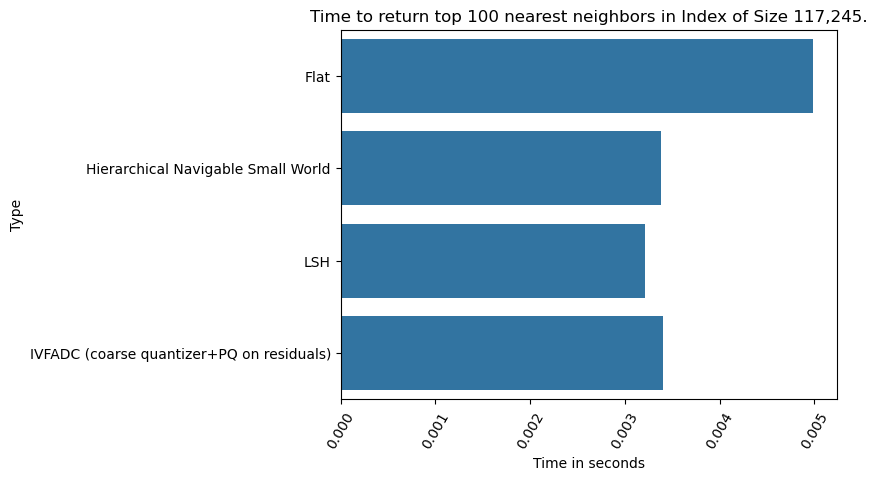

In [9]:
results_df = pd.DataFrame(results, columns = ["Type", "Time", "Accuracy"])
display(results_df)
sns.barplot(data= results_df, y = 'Type', x = 'Time')
plt.title("Time to return top 100 nearest neighbors in Index of Size 117,245.")
plt.xlabel("Time in seconds")
plt.xticks(rotation= 60)
plt.show()

# Processing Text Fields

### Failed attempt
Originally, I vectorized these text entries with CLIP and tried to use the resulting vectors in my similarity search for the original text query string. This did not work well at all. There just wasn't enough information in the object text fields, and using the LLM was time-consuming and bulky.


### Best approach
Instead, I went back to the HAM database and pulled existing AI-generated annotations. I concatenated these with the database text fields, such as artist, title, etc. I then used TF-IDF via scikit-learn’s tfidf_vectorizer to compare the images with a text query using cosine similarity. This worked very well. I put the tfidf matrix into a Faiss vector store for quick comparison using a Flat Index.

Below, I am cleaning extra characters from fields, combining two date columns to make one complete date field, and pulling people’s qualities, such as name and culture, from the people dictionary. 

In [13]:
# remove 'Department of"
df['department'] = df['department'].str.replace('Department of ', '')

# remove extra characters
df['period'] = df['period'].str.replace('c.|\(|\)', '', regex=True)

# merge two date columns to get a complete date columns
df['date'] = np.where(df['dateend'] == 0, df['dated'], df['dateend'])

def extract_from_people(people_entry, field):
    """ Extract field information from people field."""
    
    try:
        if isinstance(people_entry, str):
            # Safely evaluate string to Python object
            data = ast.literal_eval(people_entry)
        else:
            # Already in object form
            data = people_entry
        
        # Handle case where data is a list of dictionaries
        if isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and field in item:
                    return item[field]
        
        # Handle case where data is a single dictionary
        elif isinstance(data, dict) and field in data:
            return data[field]
            
        return None
    except (ValueError, SyntaxError):
        return None

# create artist name and culture fields by extracting from the people field
person_fields =  ['name', 'culture']       
for field in person_fields: 
    df['artist_' + field] = df['people'].apply(extract_from_people, args = (field,))

In [14]:
# Create one field that will hold all of the text data for tfidf 
df["search_text"] = (
    df["title"].fillna(" ") + " | " + 
    df["period"].fillna(" ") + " | " + 
    df["classification"].fillna(" ") + " | " + 
    df["division"].fillna(" ") + " | " + 
    df["date"].astype(str).replace("nan", " ") + " | " + 
    df["department"].fillna(" ") + " | " + 
    df["artist_name"].fillna(" ") + " | " + 
    df["artist_culture"].fillna(" ") + " | " + 
    df["medium"].fillna(" ")
)

# remove extra separators
df["search_text"] = df["search_text"].str.replace(r"\s*\|\s*\|\s*", " | ", regex=True).str.strip("| ")

display(df[['search_text']][:5])

,search_text
0,"Friedrich Wilhelm von Schadow in His Studio, Painting ""The Ascension of Mary"" | Prints | European and American Art | 1845 | Prints | Henry Ritter | German | Lithograph, chine collé, on off-white wove paper"
1,Studies of Women and Lokapurusha | Drawings | Asian and Mediterranean Art | 1855 | Islamic & Later Indian Art | | Gray-black and brown inks and watercolor on beige laid paper
2,Ceiling Fixture | Drawings | Modern and Contemporary Art | 1994 | Drawings | Catherine Murphy | American | Graphite on off-white wove paper
3,Branch of Plum Blossoms -- Illustration from the Ten Bamboo Studio Manual of Calligraphy and Painting (Shizhuzhai shuhua pu) | Ming 1368-1644 to Qing 1644-1911 dynasty | Prints | Asian and Mediterranean Art | 1703 | Asian Art | Hu Zhengyan 胡正言 | Chinese | One page from a woodblock printed book mounted as an album leaf; ink and color on paper
4,Spinner at the Door of the House | Prints | European and American Art | 1689 | Prints | Adriaen van Ostade | Dutch


In [16]:
# combine formatted database text data with annotations 
df['body'] = (df['body'] + df['search_text'])
display(df[['body']][:3])

,body
0,"The image depicts an artist's studio or workspace. In the center, an older man is seated in a chair, appearing to be an artist working on a painting or drawing. Behind him, there is a partially completed painting or artwork on an easel. In the background, a figure, likely a person, is standing and observing the artist at work. The room contains various artistic supplies, tools, and furnishings typical of a studio setting. This is a detailed pencil or lithograph drawing of what appears to be an artist's studio. The main focus is on an artist sitting in a relaxed position in front of a large canvas or painting. He's wearing a top hat and coat, and appears to be taking a break or contemplating his work. On the canvas, there's a sketch or outline of what looks like a religious figure. The studio space includes a window with panes on the left, some curtains, and various artist's materials and supplies scattered about, including what seems to be a table with tools or materials. In the background, there's another figure standing near a doorway. The drawing has a casual, candid quality that captures a moment in the daily life of an artist at work. The title or signature at the bottom appears to read ""M. Sébastien.""Friedrich Wilhelm von Schadow in His Studio, Painting ""The Ascension of Mary"" | Prints | European and American Art | 1845 | Prints | Henry Ritter | German | Lithograph, chine collé, on off-white wove paperFriedrich Wilhelm von Schadow in His Studio, Painting ""The Ascension of Mary"" | Prints | European and American Art | 1845 | Prints | Henry Ritter | German | Lithograph, chine collé, on off-white wove paper"
1,"The image appears to be a surreal, abstract drawing or sketch. It contains various elements, including human figures, architectural structures, and abstract shapes and patterns. The style is loose and expressive, with a mixture of pencil, ink, and color markings. The overall composition is complex and layered, creating a dreamlike or subconscious atmosphere. There are no identifiable individuals in the image, only suggestive human forms and faces. This appears to be a historical sketch or drawing with multiple elements. The main figure in the lower left portion is drawn in a dynamic pose. The sketch includes various decorative elements in the upper right, including what appears to be architectural details with arches and ornamental designs. There are also small animal figures, possibly elephants, sketched in the upper portion of the drawing. The artwork has a loose, gestural quality with lines in different colors including red, black, blue and green. The paper appears aged, with a beige or off-white tone. The composition has a somewhat chaotic or energetic feel, with multiple figures and elements arranged across the page in what seems to be a preparatory or study drawing.Studies of Women and Lokapurusha | Drawings | Asian and Mediterranean Art | 1855 | Islamic & Later Indian Art | | Gray-black and brown inks and watercolor on beige laid paperStudies of Women and Lokapurusha | Drawings | Asian and Mediterranean Art | 1855 | Islamic & Later Indian Art | | Gray-black and brown inks and watercolor on beige laid paper"
2,"This black and white image shows a ceiling light fixture with a round, dome-shaped cover. The ceiling has a heavily textured, popcorn-like surface. There appears to be a pull cord or chain hanging down from one side of the fixture with a circular pull ring at the end. The light fixture itself looks somewhat aged or worn, with some visible marks or discoloration on its surface. The composition is simple and straightforward, shot from below looking directly up at the ceiling light. The image appears to be a black and white photograph depicting a circular object, likely a mirror or lens, set against a textured, abstract background. The background has a rough, granular texture, creating an interesting visual contrast with the smooth, reflective surface of the circular object in the center. The 

## Creating TF-IDF matrix and using it for cosine similarity comparisons against text query

I use scikit-learn’s TfidfVectorizer to transform each record into a vector that can be compared with the others based on the inclusion of words rare to the entire corpus. I did a grid search over possible hyperparameters. The difficulty with this technique is the absence of any natural ground truth.  To create a senerio where I could hand the grid search a ground truth to evaluate with I reandomly selected 100 image/description pairs and manually created queries that I thought should be of high cosine similarity to the description/image pair. This technique is flawed for a number of reasons, one my inupt is subjective and two I am only embedding a set of 100 text samples. My actual modle will be embedding 117,000 texts so may need different parameters for that reason alone. But the grid search returned optimal parameters: max_features = 10000, and ngram_range = (1, 1), upon inspection I can see that altering the min_df parameter selection did not affect the scoring at all.

Upon seeing the results of the parameter grid search and trying different hyperparamters with my final recommender I decided to remove English stop words, use the ngram range of 1-2, meaning that I can capture just single words as well as phrases up to two words long. And I build a vocabulary that usses the top 15000 terms. This choice is appropriate for art terms and artist name queries, which are often 2 words or less. Here, I ignore words that are in less than two documents. 


In [16]:
# first do a grid search for parameters on a small version of dataset

grid_df = pd.read_csv("ground_truth.csv")
# My ground truth sample queries
queries = [
    'Artist in studio', 'Still life fruit', 'Ornamental pattern', 
    '17th century portrait', 'Historic Battle Scene', 'Medieval carving',
    'Watercolor of boats', 'Boats in water', 'Military scene',
    'Engraving of festival', '17th century Islamic manuscript', 
    'Simple Sculpture', 'Art with buildings', 'Cubist animal sculpture',
    'Jael Slaying Sisera', 'Shards of ancient clay pots', 'Nude figure',
    'Roman painting fragment', 'Art gallery photographic image', 
    'Saint Francis artwork'
]

# Ground truth mapping (query index : document index)
ground_truth = {
    0: [0], 1: [8], 2: [11], 3: [12], 4: [13], 5: [15], 6: [17], 7: [69],
    8: [22], 9: [25], 10: [30], 11: [35], 12: [59], 13: [52], 14: [61], 
    15: [62], 16: [65], 17: [77], 18: [3], 19: [86]
}

param_grid = {
    'ngram_range': [(1, 1), (1, 2), (1, 3)],
    'min_df': [1, 2, 5],
    'max_features': [5000, 10000, 15000, 20000],
}

def evaluate_retrieval(tfidf, tfidf_matrix, queries, ground_truth):
    """Calculate average cosine similarity between queries and their ground truth indices."""
    query_vecs = tfidf.transform(queries)
    scores = []
    
    for query_idx, doc_indices in ground_truth.items():
       
        # Get ground truth vectors
        gt_vecs = tfidf_matrix[doc_indices]
        
        # Calculate similarity between query and its ground truth docs
        sim = cosine_similarity(query_vecs[query_idx:query_idx+1], gt_vecs)
        scores.append(np.mean(sim))
    
    return np.mean(scores)

results = []
for params in tqdm(ParameterGrid(param_grid)):
    tfidf = TfidfVectorizer(**params)
    tfidf_matrix = tfidf.fit_transform(grid_df['body']) 
    
    score = evaluate_retrieval(tfidf, tfidf_matrix, queries, ground_truth)
    
    results.append({
        **params,
        'score': score,
        'vocab_size': len(tfidf.get_feature_names_out())
    })

results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['score'].idxmax()]
print(best_params)
display(results_df.sort_values('score', ascending = False).iloc[:20])

100%|███████████████████████████████████████████| 36/36 [12:52<00:00, 21.46s/it]

max_features       10000
min_df                 1
ngram_range       (1, 1)
score           0.246763
vocab_size         10000
Name: 9, dtype: object


,max_features,min_df,ngram_range,score,vocab_size
9,10000,1,"(1, 1)",0.246763,10000
15,10000,5,"(1, 1)",0.246763,10000
12,10000,2,"(1, 1)",0.246763,10000
18,15000,1,"(1, 1)",0.244175,15000
24,15000,5,"(1, 1)",0.244175,15000
21,15000,2,"(1, 1)",0.244175,15000
33,20000,5,"(1, 1)",0.242891,20000
30,20000,2,"(1, 1)",0.242891,20000
27,20000,1,"(1, 1)",0.242891,20000
0,5000,1,"(1, 1)",0.233667,5000


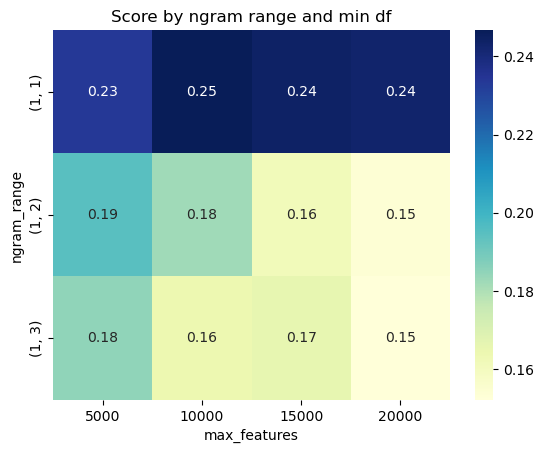

In [24]:

heatmap_data = results_df.pivot_table(
    index='ngram_range', 
    columns='max_features', 
    values='score',
    aggfunc='mean'
)

sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Score by ngram range and min df')
plt.show()

In [22]:
# Create TF-IDF matrix this is the code that I use for the final product
tfidf = TfidfVectorizer(
    stop_words='english', # do not process common english words
    ngram_range=(1, 1),  # capture single words and phrases


)
tfidf_matrix = tfidf.fit_transform(df['body'])

# save the vectorizer and matrix to file to load in the recommender later
dump({"vectorizer": tfidf, "matrix": tfidf_matrix}, "tfidf_data_test.joblib")





['tfidf_data_test.joblib']

In [ ]:
# I was using this for searching the tdif vector but it turns out that it is not necessary and takes too much space

# convert sparse matrix to dense 
dense_matrix = tfidf_matrix.toarray().astype("float32")

# build the FAISS index
tfidf_index = faiss.IndexFlatIP(dense_matrix.shape[1])  
tfidf_index.add(dense_matrix)

# save this vector store to file for later use in recommender
faiss.write_index(tfidf_index, "tfidf_index_test.faiss")

In [ ]:
# Create TF-IDF matrix
tfidf = TfidfVectorizer(
    stop_words='english', # do not process common english words
    ngram_range=(1, 1),  # capture single words and phrases 
    max_features = 30000
)
tfidf_matrix = tfidf.fit_transform(df['body'])

# save the vectorizer and matrix to file to load in the recommender later
dump({"vectorizer": tfidf, "matrix": tfidf_matrix}, "tfidf_data_test.joblib")

d = dense_matrix.shape[1]  # TF-IDF dimension


# Accuracy-focused parameters
nlist = min(10000, int(np.sqrt(dense_matrix.shape[0])))  # More clusters for better accuracy
m = min(30, d)  # Max sub-quantizers (up to 32)
bits = 10  # Higher bit depth for better precision

# Use OPQ preprocessing for better vector distribution
opq_matrix = faiss.OPQMatrix(d, m)
train_sample = dense_matrix[np.random.choice(dense_matrix.shape[0], 
                           min(200000, dense_matrix.shape[0]), 
                           replace=False)]
opq_matrix.train(train_sample)
dense_matrix_opq = opq_matrix.apply_py(dense_matrix)

# Build the index
quantizer = faiss.IndexFlatIP(d)  # Exact inner product
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits)

# Train with more data
index.train(dense_matrix_opq[train_sample])

# Enable accuracy-enhancing options
index.do_polysemous_training = True
index.cp.min_points_per_centroid = 20  # Ensure good cluster coverage
index.cp.max_points_per_centroid = 5000  # Allow large clusters

index.add(dense_matrix_opq)
faiss.write_index(index, "tfidf_index_test.faiss")


In [11]:
d = dense_matrix.shape[1]
m = 30
index = faiss.IndexHNSWPQ(d, m, 8)
index.train(dense_matrix)
index.add(dense_matrix)
# save this vector store to file for later use in recommender
faiss.write_index(index, "tfidf_index_test.faiss")

In [9]:
df = pd.read_csv("final_toy_HAMtest.csv")
display(df.head)

<bound method NDFrame.head of         Unnamed: 0  objectid  \
0                0    188623   
1                1    217273   
2                2    184460   
3                3    205821   
4                4    249077   
...            ...       ...   
117240       33240    386739   
117241       33241    386741   
117242       33242    386925   
117243       33243    386929   
117244       33244    387887   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      title  \
0                                                                                                         

In [10]:
small_df = df.drop(['body', 'image_embedding', 'rank', 'imageid', 'search_text', 'Unnamed: 0'], axis = 1)
display(small_df.head())
small_df.to_csv("small_HAM.csv")

,objectid,title,primaryimageurl,date,artist_name
0,188623,"Friedrich Wilhelm von Schadow in His Studio, Painting ""The Ascension of Mary""",https://nrs.harvard.edu/urn-3:HUAM:INV043609_dynmc,1845,Henry Ritter
1,217273,Studies of Women and Lokapurusha,https://nrs.harvard.edu/urn-3:HUAM:71672_dynmc,1855,NaN
2,184460,Ceiling Fixture,https://nrs.harvard.edu/urn-3:HUAM:797681,1994,Catherine Murphy
3,205821,Branch of Plum Blossoms -- Illustration from the Ten Bamboo Studio Manual of Calligraphy and Painting (Shizhuzhai shuhua pu),https://nrs.harvard.edu/urn-3:HUAM:CARP07564_dynmc,1703,Hu Zhengyan 胡正言
4,249077,Spinner at the Door of the House,https://nrs.harvard.edu/urn-3:HUAM:INV193037_dynmc,1689,Adriaen van Ostade


## Check to see if there is any difference in similarity results between FAISS and brute force cosine similarity

Here, I try both a brute force cosine search using tfidf and I also try putting the tfidf matrix into Faiss with a flat index for fast cosine search. The returned nearset neighbor vectors were identical with each other, so I will stick with using Faiss and, as my object size grows, may consider using a different Faiss search technique.

In [20]:
# Load and use
#data = load("tfidf_data4.joblib")
#vectorizer, tfidf_matrix = data["vectorizer"], data["matrix"]


# Query jumping cat
query = ["jumping cat"]
query_vec = tfidf.transform(query)

# Find similar docs using FAISS 
D, I = tfidf_index.search(query_vec.toarray().astype("float32"), k=8)
print("Top matches FAISS:", [i for i in I[0]])

# Find similar items using cosine similarity
cosine_sim = cosine_similarity(query_vec, tfidf_matrix)
top_indices = cosine_sim.argsort()[0][-8:][::-1]  
print("Top matches Cosine_sim:", top_indices)


Top matches FAISS: [11417, 100367, 27392, 74015, 15913, 50163, 46133, 6321]
Top matches Cosine_sim: [ 11417 100367  27392  74015  15913  50163  46133   6321]


## Examples of search with text strings 'jumping cat' and 'vibrant abstract landscape'

In [15]:
# Query vibrant abstract landscape
query = "vibrant abstract landscape"
query_vec = tfidf.transform([query])
# Find similar items using cosine similarity
cosine_sim = cosine_similarity(query_vec, tfidf_matrix)
top_indices = cosine_sim.argsort()[0][-8:][::-1]  
print(top_indices)

print("Query 'Jumping Cat'")
for i in I[0]:
    url = df.iloc[i]['primaryimageurl']
    display(Image_show(url = url, width = 300))

print("Query 'vibrant abstract landscape'")
for i in top_indices:
    url = df.iloc[i]['primaryimageurl']
    display(Image_show(url = url, width = 300))   

[116726   3904  84119  58605 115847  83748  53100  15952]
Query 'Jumping Cat'


Query 'vibrant abstract landscape'


## This seems to have worked well


In [31]:
# here I drop final uneeded columns and save resultant df to a csv to use in the final recommender
dropped = ['Unnamed: 0.1','Unnamed: 0','id', 'division',
       'colorcount', 'period', 'classification', 'technique', 'medium',
       'colors', 'dated', 'dateend', 'department', 'people',
       'url', 'publicationcount', 'totaluniquepageviews',
        'totalpageviews', 'exhibitioncount',  
         'artist_culture']

df.drop(dropped, inplace=True, axis = 1)


In [36]:
df.columns

Index(['objectid', 'title', 'primaryimageurl', 'rank', 'imageid', 'body',
       'image_embedding', 'date', 'artist_name', 'search_text'],
      dtype='object')

In [32]:
#df.to_csv('final_toy_HAM4.csv')
df.to_csv('final_toy_HAMtest.csv')


# Building search and recommendation Engine
---
The final output of this project is the below HAM_recommend class. It uses Jupyter widgets as UI elements to input user text query, likes, and query for recommendations. The event interface is driven by text entry and button clicks. Output is displayed by image cards via accordion widgets. Each query has its own accordion output.

The model Deepseek was used to generate a portion of the UI for the below recommendation system, namely the image cards and the accordion sections in the recommendation class. The validation of this code involves using the Recommender. I have performed approximately 50 searches post-building and have not seen any bugs or unusual behavior in the UI. The prompts used included: "I have this code (paste code) and I would like to put like buttons with my images that will save the liked indexes to my class variable.", also "I would like to try to find a way to display all history of search but make it collapsible. (paste code)"

In [ ]:
df = pd.read_csv('final_toy_HAM4.csv')
display(df.head(2))

## Sample Output
---
I spent many hours getting the recommender UI to work perfectly, only to realize that I could not easily export the results of my queries because they are widgets. I instead took screenshots of the results that are posted below. You can see that liked items have like buttons that are a darker color of gray.

## **Search: circus cat** 

Here I enter a query that will return two different types of imagery, 'circus' and 'cat.’ By liking only circus imagery, I am returned images that focus only on the circus aspect. The next round of recommendations, I unlike the circus themes and only images with Asian themes, and my recommender returns images based on that selection.

### The results from the HAM website

In [2]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time




class HAM_recommend():
    """ Creates a Jupyter widget based UI that queries user for image search text, 
     allows them to like images, and provides image recommendations based on liked images.
     usage:
     rec = HAM_recommend()
     rec.show()
    """
    
    def __init__(self):
        self.df = pd.read_csv('final_toy_HAMtest.csv')
        self.query = ""
        self.liked = []
        self.all_displayed_indices = set()  # Track ALL images ever displayed
        self.current_displayed_indices = set() 
        self.image_index = faiss.read_index("image_index4.faiss")
        self.text_index = faiss.read_index("tfidf_index_test.faiss")
        self.tfidf = load("tfidf_data_test.joblib")["vectorizer"]
        self.main_output = widgets.Output()
        self.run = True
        self.image_widgets = []
        
        # container for all batches
        self.batches_container = widgets.VBox()
        display(self.batches_container)
        
        # counter for batch IDs
        self.batch_counter = 0
        self.image_grid = widgets.GridBox(
            layout=widgets.Layout(
                grid_template_columns="repeat(3, 300px)",
                grid_gap="10px",
                width='100%'
            )
        )
        self.current_batch_name = None 

    def download_image(self, url):
        """Download single image from given url"""
        try:
            response = requests.get(url, timeout=8)
            if response.status_code == 200:
                return BytesIO(response.content).read()
            return None
        except:
            return None
            
    def create_image_card(self, idx, score):
        """Create a widget card for an image with like button"""
        image_widget = widgets.Image(
            width=280, 
            height=280,
            layout=widgets.Layout(visibility='hidden')
        )
        
        like_button = widgets.ToggleButton(
            value=idx in self.liked,
            description='❤️ Like',
            layout=widgets.Layout(width='auto')
        )
        
        caption = widgets.HTML(
            value=f"<b>Score:</b> {score:.2f}<br>Loading image..."
        )
        
        card = widgets.VBox([
            image_widget,
            caption,
            like_button
        ], layout=widgets.Layout(
            border='solid 1px gray',
            padding='10px',
            min_height='350px'
        ))
        
        like_button.index = idx
        like_button.observe(self.on_like_change, names='value')
        
        return card, image_widget, caption

    def on_like_change(self, change):
        """ Allows user to like or unlike image with button click, 
        allows creating recommendations if number of likes is more than 0"""
        idx = change['owner'].index
        if change['new']:
            if idx not in self.liked:
                self.liked.append(idx)
        else:
            if idx in self.liked:
                self.liked.remove(idx)
        self.rec_button.disabled = len(self.liked) == 0  # Update button state

    def search_for_text(self, button=None):
        """Search for and return similar objects when prompted with 
        query text. Vectorizes querry text with tfidf vectorizor then 
        performs similary search with the faiss text vector store"""
        self.query = self.search_text.value
        with self.main_output:
            clear_output()
            print(f"Searching for: {self.query}")
        
        # Create query vector
        query_vec = self.tfidf.transform([self.query])
        
        # Get results
        D, I = self.text_index.search(query_vec.toarray().astype("float32"), k=12)
        
        # Show with header 
        self.show_images(I[0], D[0], batch_name=f"Search Results for: '{self.query}'")
     
                    

    def show_images(self, indices, scores, batch_name=None, requested_count=12, fetch_multiplier=3):
        """Displays images in a new collapsible batch after filtering duplicates."""
        with self.main_output:
            if not batch_name:
                batch_name = f"Results {self.batch_counter + 1}"
            
            # Get more candidates than needed to account for duplicates
            candidate_indices = indices[:requested_count * fetch_multiplier]
            candidate_scores = scores[:requested_count * fetch_multiplier]
            
            # Filter out already displayed images
            new_indices = []
            new_scores = []
            for idx, score in zip(candidate_indices, candidate_scores):
                if idx not in self.all_displayed_indices:
                    new_indices.append(idx)
                    new_scores.append(score)
                    self.all_displayed_indices.add(idx)
                    if len(new_indices) >= requested_count:
                        break  # Stop when we have enough
            
            if not new_indices:
                print(f"No new images found for '{batch_name}'")
                return
            
            # Create batch UI elements
            batch_id = f"batch_{self.batch_counter}"
            self.batch_counter += 1
            
            image_grid = widgets.GridBox(
                layout=widgets.Layout(
                    grid_template_columns="repeat(3, 300px)",
                    grid_gap="10px",
                    width='100%'
                )
            )
            
            # Create and load image cards
            cards = []
            for idx, score in zip(new_indices, new_scores):
                card, img_widget, caption = self.create_image_card(idx, score)
                cards.append(card)
                
                url = self.df.iloc[idx]['primaryimageurl']
                image_data = self.download_image(url)
                if image_data:
                    img_widget.value = image_data
                    img_widget.layout.visibility = 'visible'
                    title = str(self.df.iloc[idx].title)
                    name = str(self.df.iloc[idx].artist_name)
                    date = str(self.df.iloc[idx].date)
                    info = title + ', ' + name + ', ' + date 
                    caption.value = f"{info}<br><b>Score:</b> {score:.2f}"
            
            image_grid.children = cards
            
            # Add to history
            accordion = widgets.Accordion(children=[image_grid])
            accordion.set_title(0, batch_name)
            accordion.selected_index = None
            self.batches_container.children += (accordion,)

    
    def search_by_likes(self, button=None):
        """Using list of liked images, extract thier embeddings, average them
        and query the faiss image vector store for similar images. Filter already 
        seen images and display. """
        if not self.liked:
            with self.main_output:
                print("Please like some images first!")
            return
        
        try:
            liked_embeddings = [np.array(eval(self.df.iloc[idx]['image_embedding'])) 
                              for idx in self.liked]
            avg_embedding = np.mean(liked_embeddings, axis=0).reshape(1, -1).astype('float32')
            
            D, I = self.image_index.search(avg_embedding, k=36)  # Get 3x more than needed
            
            self.show_images(I[0], D[0], batch_name="Recommended Based On Your Likes")
            
        except Exception as e:
            with self.main_output:
                print(f"Error getting recommendations: {str(e)}")
                
    def clear_likes(self, button):
        """Clear all liked images and refresh the UI"""
        self.liked = []
        with self.main_output:
            clear_output()
            print("Cleared all likes")
        
        # Update the recommendation button state
        self.rec_button.disabled = True
        
        # Update all like buttons in existing cards
        for accordion in self.batches_container.children:
            for grid in accordion.children:
                for card in grid.children:
                    like_button = card.children[2]  # Like button is the 3rd child
                    like_button.value = False                
                    

    
    def text_query_HAM(self):
        """Create search UI box with text query button, get 
        recomendations button, and clear all likes button."""
        search_box = widgets.HBox([
            widgets.Text(description="Search:", layout=widgets.Layout(width='400px')),
            widgets.Button(description="Find Images")
        ])

        self.search_text = search_box.children[0]
        search_button = search_box.children[1]
        
        # Create recommendation button
        self.rec_button = widgets.Button(
            description="Get Recommendations Based on Likes",
            disabled=len(self.liked) == 0,
            layout=widgets.Layout(width='auto', margin='10px')
        )
        
        # Create clear likes button
        clear_likes_button = widgets.Button(
            description="Clear All Likes",
            button_style='danger',
            layout=widgets.Layout(width='auto', margin='10px')
        )
        
        # Connect buttons to their functions
        search_button.on_click(self._on_search_click)
        self.rec_button.on_click(lambda b: self.search_by_likes())
        clear_likes_button.on_click(self.clear_likes)
        
        # Create button container
        button_row = widgets.HBox([
            self.rec_button,
            clear_likes_button
        ], layout=widgets.Layout(
            justify_content='center',
            margin='10px 0'
        ))
        
        # display all UI elements
        display(search_box)
        display(button_row)
        display(self.main_output)
    
    def _on_search_click(self, button):
        """Handle search with basic spelling correction"""
        self.query = self.search_text.value
        self.search_for_text()
    
    def show(self): 
        """Main display method"""
        self.text_query_HAM()
        

    
    def download_image(self, url):
        """Download single image from given url with timeout"""
        try:
            response = requests.get(url, timeout=8)
            if response.status_code == 200:
                return BytesIO(response.content).read()
            return None
        except Exception as e:
            return None
            
    def download_images_concurrently(self, urls):
        """Download multiple images concurrently using threading"""
        results = {}
        with ThreadPoolExecutor(max_workers=10) as executor:
            # Start the download operations and mark each future with its URL
            future_to_url = {executor.submit(self.download_image, url): url for url in urls}
            
            for future in as_completed(future_to_url):
                url = future_to_url[future]
                try:
                    results[url] = future.result()
                except Exception as e:
                    results[url] = None
        return results

    def show_images(self, indices, scores, batch_name=None, requested_count=12, fetch_multiplier=3):
        """Displays images in a new collapsible batch after filtering duplicates."""
        with self.main_output:
            if not batch_name:
                batch_name = f"Results {self.batch_counter + 1}"
            
            # Get more candidates than needed to account for duplicates
            candidate_indices = indices[:requested_count * fetch_multiplier]
            candidate_scores = scores[:requested_count * fetch_multiplier]
            
            # Filter out already displayed images
            new_indices = []
            new_scores = []
            for idx, score in zip(candidate_indices, candidate_scores):
                if idx not in self.all_displayed_indices:
                    new_indices.append(idx)
                    new_scores.append(score)
                    self.all_displayed_indices.add(idx)
                    if len(new_indices) >= requested_count:
                        break  # Stop when we have enough
            
            if not new_indices:
                print(f"No new images found for '{batch_name}'")
                return
            
            # Create batch UI elements
            batch_id = f"batch_{self.batch_counter}"
            self.batch_counter += 1
            
            image_grid = widgets.GridBox(
                layout=widgets.Layout(
                    grid_template_columns="repeat(3, 300px)",
                    grid_gap="10px",
                    width='100%'
                )
            )
            
            # Get all URLs first
            urls = [self.df.iloc[idx]['primaryimageurl'] for idx in new_indices]
            
            # Download all images concurrently
            start_time = time.time()
            downloaded_images = self.download_images_concurrently(urls)
            print(f"Downloaded {len(urls)} images in {time.time() - start_time:.2f} seconds")
            
            # Create and load image cards
            cards = []
            for idx, score, url in zip(new_indices, new_scores, urls):
                card, img_widget, caption = self.create_image_card(idx, score)
                cards.append(card)
                
                image_data = downloaded_images[url]
                if image_data:
                    img_widget.value = image_data
                    img_widget.layout.visibility = 'visible'
                    title = str(self.df.iloc[idx].title)
                    name = str(self.df.iloc[idx].artist_name)
                    date = str(self.df.iloc[idx].date)
                    info = title + ', ' + name + ', ' + date 
                    caption.value = f"{info}<br><b>Score:</b> {score:.2f}"
                else:
                    caption.value = f"<b>Error loading image</b><br><b>Score:</b> {score:.2f}"
            
            image_grid.children = cards
            
            # Add to history
            accordion = widgets.Accordion(children=[image_grid])
            accordion.set_title(0, batch_name)
            accordion.selected_index = None
            self.batches_container.children += (accordion,)

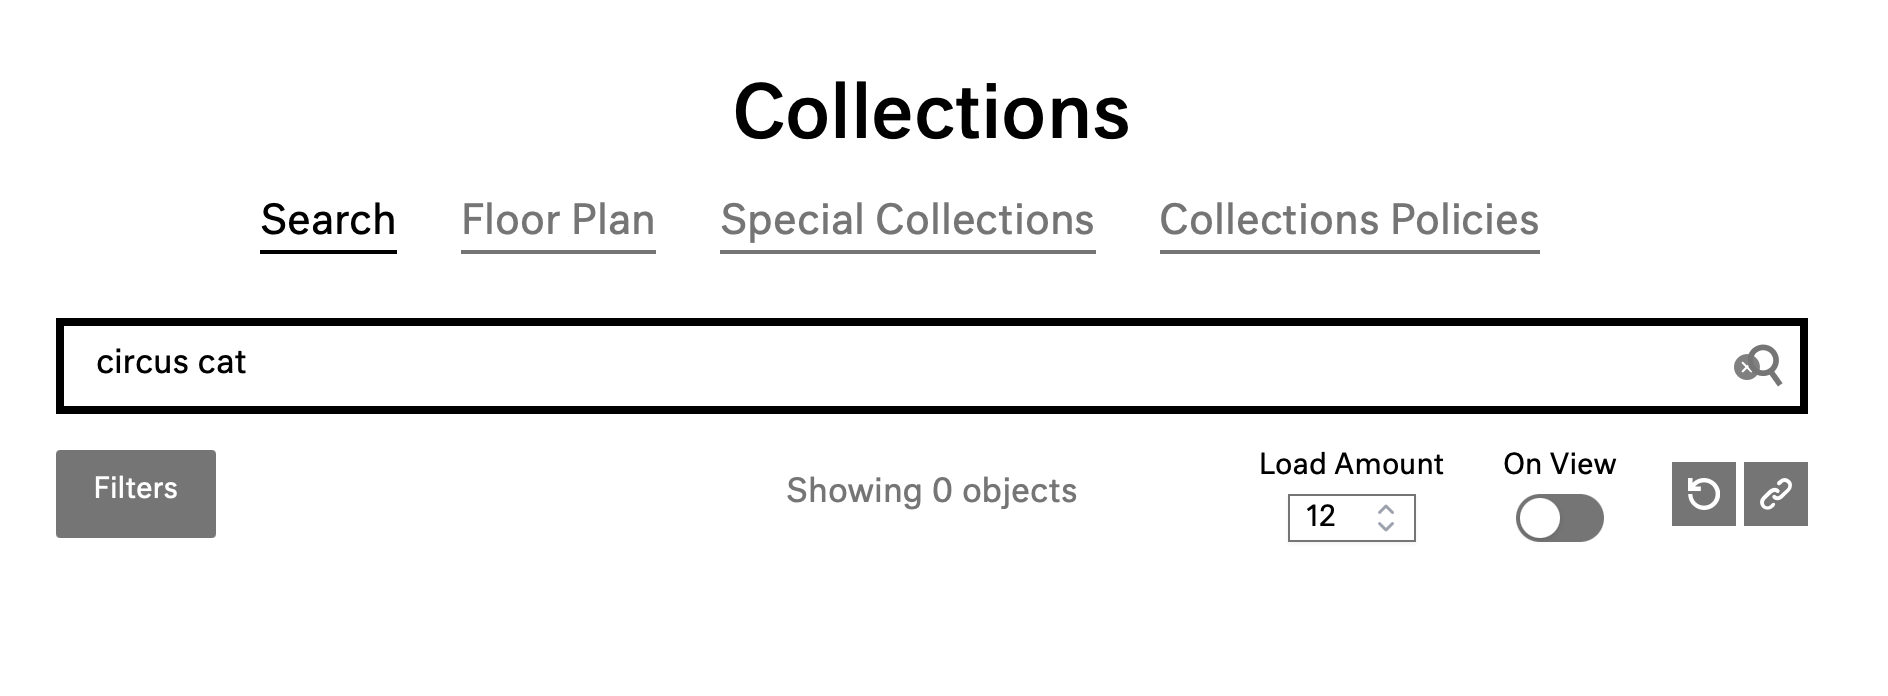

In [16]:

with open("Screenshot 2025-05-06 at 1.15.28 PM.png", "rb") as f:
    display(Image_show(f.read(), width=1000))

### My results

In [5]:
# Create and display the recommender
rec = HAM_recommend()
rec.show()

VBox()

Output()

## **Search: 'ancient chinese vase'** 

Here I search for ancient chinese vase. The search returns matching items. I 'like' the items that look most like traditional ancient chinese vases and the returned recommendations mirrors that.

### Results from HAM:

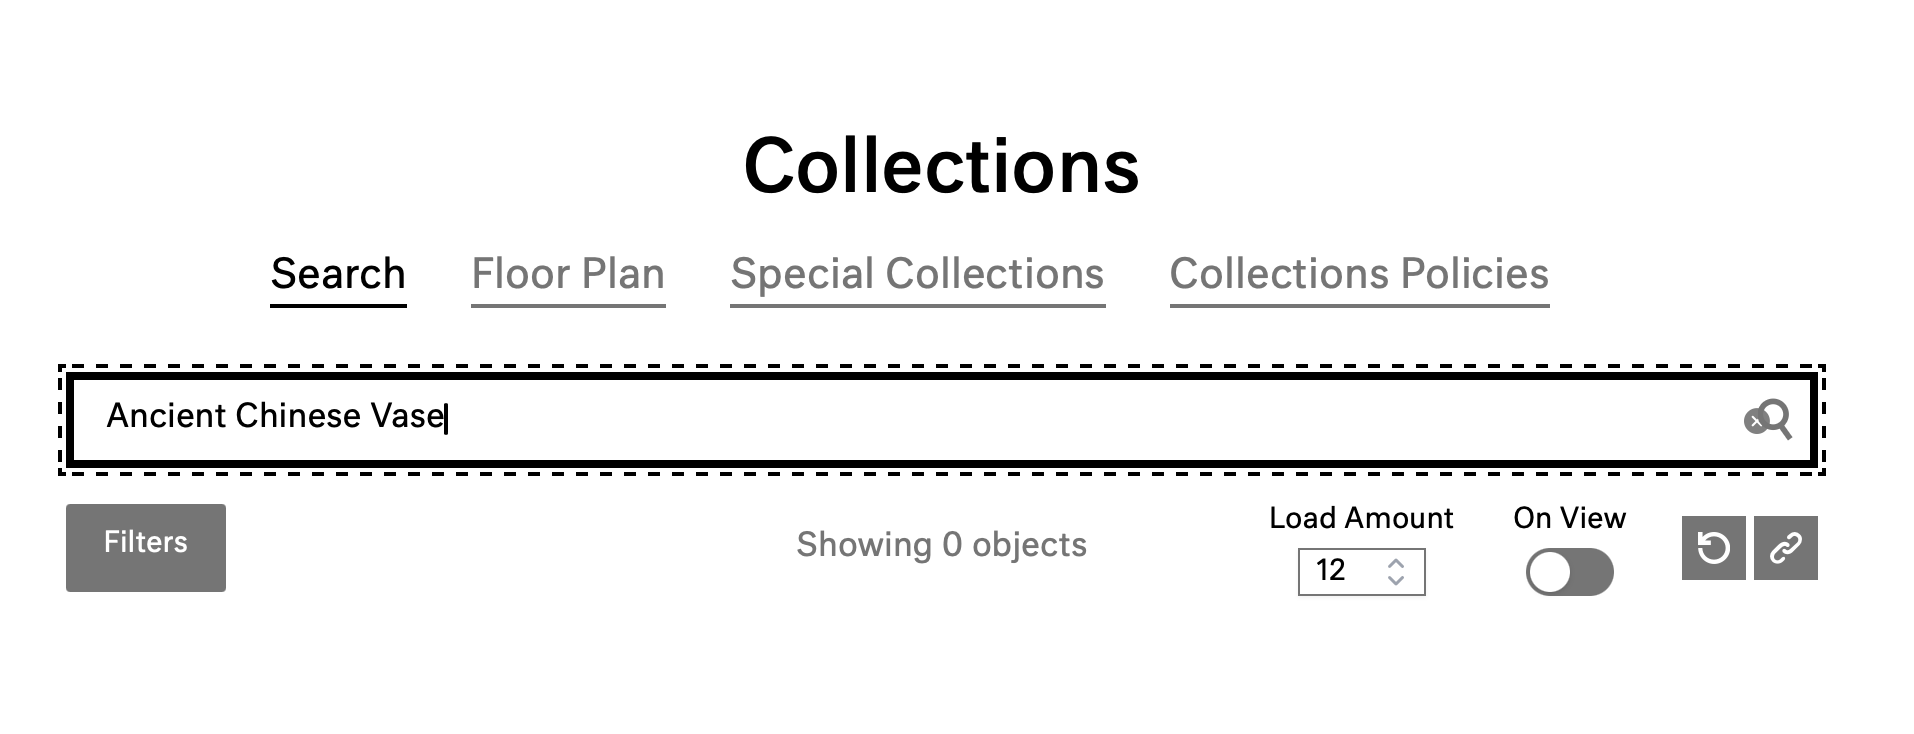

In [22]:


with open("Screenshot 2025-05-06 at 1.16.20 PM.png", "rb") as f:
    display(Image_show(f.read(), width=1000))

    

### My results

In [6]:
# Create and display the recommender
rec = HAM_recommend()
rec.show()

VBox()

Output()

## **Search: Greek Art**
Here I liked the images most similar to classic greek statues and was returned all statues.

In [8]:
# Create and display the recommender
rec = HAM_recommend()
rec.show()

VBox()

Output()

## Searching for degas dancer
Here I enter the query term Degas Dancer. I next like the most colorful Degas dancer image and am recommended other bright paintings/drawings of dancers.

In [7]:
# Create and display the recommender
rec = HAM_recommend()
rec.show()

VBox()

Output()

# References
---
CLIP-Art: Contrastive Pre-Training for Fine-Grained Art Classification, Marcos V. Conde, Kerem Turgutlu; Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR) Workshops, 2021, pp. 3956-3960 [https://openaccess.thecvf.com/content/CVPR2021W/CVFAD/papers/Conde_CLIP-Art_Contrastive_Pre-Training_for_Fine-Grained_Art_Classification_CVPRW_2021_paper.pdf]

Faiss Facebook Similarity Search:
Billion-scale similarity search with GPUs, Jeff Johnson, Matthijs Douze, Hervé Jégou, ArXiv 2017, [https://arxiv.org/abs/1702.08734]
[https://github.com/facebookresearch/faiss/wiki/]

CLIP
[https://openai.com/index/clip/]

About HAM AI Anotations
[https://ai.harvardartmuseums.org/statistics]

Harvard Art Museum API docs
[https://github.com/harvardartmuseums/api-docs/blob/master/sections/object.md]

Harvard Art Museum Collections Homepage
[https://harvardartmuseums.org/collections]

DeepSeek
[https://chat.deepseek.com]

**AI Description Annotations Made by:**
* Amazon Nova (via AWS Bedrock) : Description generation via prompting
* Anthropic Claude (via AWS Bedrock) : Description generation via prompting
* Clarifai : Concepts
* Google Gemini : Description generation via prompting
* Meta Llama (via AWS Bedrock) : Description generation via prompting
* Microsoft Cognitive Sources : descriptions
* Mistral Pixtral (via AWS Bedrock) : Description generation via prompting
* OpenAI GPT (via Azure) : Description generation via prompting